# Custom interpolation functions in embedded datasets

The cartesian yt dataset returned by `yt_xarray.transformations.build_interpolated_cartesian_ds` consists of a cartesian grid (or set of refined grids) that will sample the underyling xarray dataset as needed. In the final step of this process, the native coordinates of the cartesian grid points are calculated (using the supplied `Transformer` object -- see previous notebooks) and then the underlying xarray dataset is sampled at those native coordinates. Because the exact values of requested native coordinates is unlikely to exist, an interpolation is required and there are a number of ways to control the interpolation:

The keyword argument, `interp_method`, can be set to `'nearest'` (the default) or `'interpolate'`. If `'nearest'`, then the nearest value to the request point is used and if `'interpolate'`, a linear interpolation will be used. In both cases, underlying xarray methods are used. For `'nearest'`, `xr.DataArray.data.sel(interp_dict, method="nearest")` and for `'interpolate'`, `xr.DataArray.interp` is used (which relies on the scipy N-D linear interpolation method). 

Additionally, you can supply your own interpolation function to `build_interpolated_cartesian_ds`. The function will be called with ``interp_func(data=data_array, coords=eval_coords)``, where
``data_array`` is an xarray ``DataArray`` and ``eval_coords`` is a list of 1d
np.ndarray ordered by the `native_coords` of the supplied transformer. The function must return an `np.ndarray` of the same shape as the ``eval_coords``. 

As an example, we'll build a custom interpolation function similar to the implementation when you set `interp_method='nearest'`.  

Let's first import all the modules we need then initialize a transformer:

In [1]:
import numpy as np 
import numpy.typing as npt
import xarray as xr
import yt_xarray
from yt_xarray.transformations import GeocentricCartesian, build_interpolated_cartesian_ds
from yt_xarray.sample_data import load_random_xr_data
from typing import List 
import yt

gc = GeocentricCartesian(radial_type='altitude', r_o=6371.)
gc.native_coords

('altitude', 'latitude', 'longitude')

The transformer `native_coords` tuple above indicates the order in which coordinate arrays will be supplied. 

To write an interpolation function that samples an `xarray.DataArray` at its nearest points:

In [2]:
def my_interp(data: xr.DataArray = None, 
              coords: List[npt.NDArray] =  None) -> npt.NDArray:
    print("hello from my_interp!")
    c0 = coords[0] # altitude 
    c1 = coords[1] # latitude
    c2 = coords[2] # longitude
    
    interp_dict = {
        'altitude':  xr.DataArray(c0, dims='points'), 
        'latitude':  xr.DataArray(c1, dims='points'), 
        'longitude':  xr.DataArray(c2, dims='points'),
    }    
    vals = data.sel(interp_dict, method='nearest')
    return vals.values

Now let's get a sample dataset to use:

In [3]:
ds = load_random_xr_data({'field1':('altitude', 'latitude', 'longitude')},
                         {'altitude': (0, 2000, 10), 
                          'latitude': (0, 20, 15), 
                          'longitude': (10, 20, 12)}, 
                          length_unit='m')

In [4]:
ds

<xarray.Dataset>
Dimensions:    (altitude: 10, latitude: 15, longitude: 12)
Coordinates:
  * altitude   (altitude) float64 0.0 222.2 444.4 ... 1.556e+03 1.778e+03 2e+03
  * latitude   (latitude) float64 0.0 1.429 2.857 4.286 ... 17.14 18.57 20.0
  * longitude  (longitude) float64 10.0 10.91 11.82 12.73 ... 18.18 19.09 20.0
Data variables:
    field1     (altitude, latitude, longitude) float64 0.9765 0.4326 ... 0.01994
Attributes:
    geospatial_vertical_units:  m

Finally, we supply the function handle of our `my_interp` function when building the interpolated dataset:

In [5]:
ds_yt = build_interpolated_cartesian_ds(ds, 
                                gc, 
                                grid_resolution=(128,128,128),
                                length_unit='m',
                                interp_func=my_interp
                                )

yt_xarray : [INFO ] 2025-11-05 16:25:34,716:  Interpolation function provided, switching interp_method to 'interpolate'.
yt : [INFO     ] 2025-11-05 16:25:34,855 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-11-05 16:25:34,856 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-11-05 16:25:34,856 Parameters: domain_left_edge          = [5625. 1039.    0.]
yt : [INFO     ] 2025-11-05 16:25:34,857 Parameters: domain_right_edge         = [8244. 2864. 2864.]
yt : [INFO     ] 2025-11-05 16:25:34,858 Parameters: cosmological_simulation   = 0


hello from my_interp!


yt : [INFO     ] 2025-11-05 16:25:36,230 xlim = 5625.000000 8244.000000
yt : [INFO     ] 2025-11-05 16:25:36,230 ylim = 1039.000000 2864.000000
yt : [INFO     ] 2025-11-05 16:25:36,232 xlim = 5625.000000 8244.000000
yt : [INFO     ] 2025-11-05 16:25:36,233 ylim = 1039.000000 2864.000000
yt : [INFO     ] 2025-11-05 16:25:36,239 Making a fixed resolution buffer of (('stream', 'field1')) 800 by 800



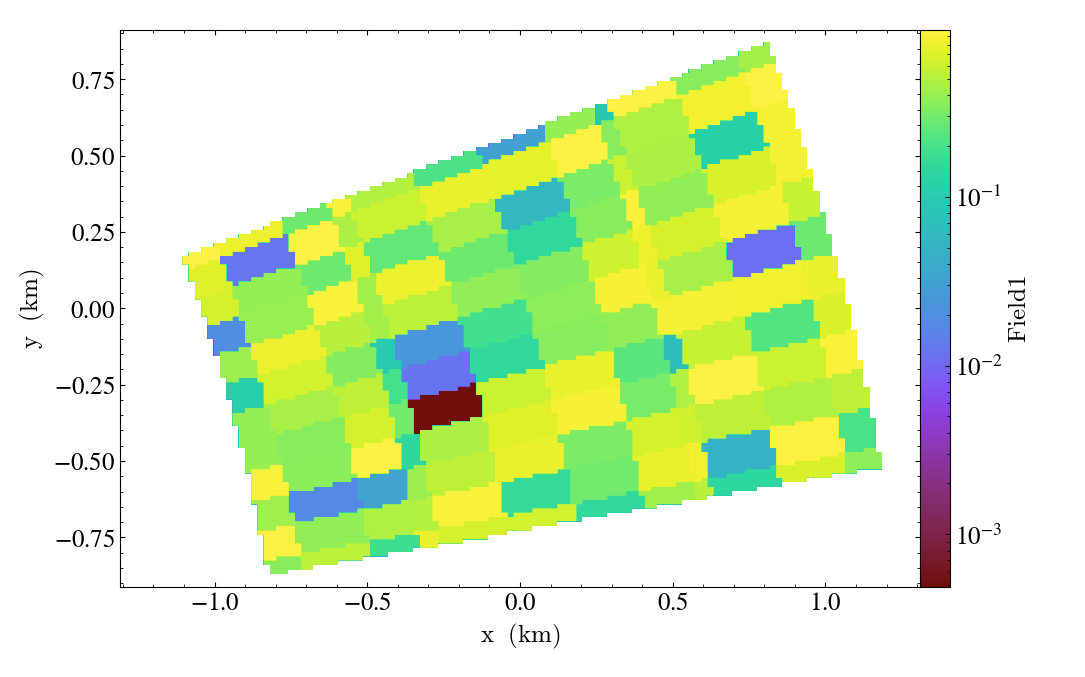

In [6]:
yt.SlicePlot(ds_yt, 'z', 'field1')

the custom interpolation function can be as complex as you need.